In [95]:
import numpy as np # linear algebra
import pandas as pd # for data preparation
import plotly.express as px # for data visualization
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [96]:
def data_input(path):
  dff=pd.read_csv(path)
  return dff

In [97]:
def data_cleaning():
  #Data Cleaning
  # Filling missing values
  netflix_data['director'].fillna('Unknown', inplace=True)
  netflix_data['cast'].fillna('No Cast', inplace=True)
  netflix_data['country'].fillna(netflix_data['country'].mode()[0], inplace=True)

  netflix_data['rating'].fillna(netflix_data['rating'].mode()[0], inplace=True)
  netflix_data['duration'].fillna(netflix_data['duration'].mode()[0], inplace=True)

  # Dropping rows with missing 'date_added'
  netflix_data.dropna(subset=['date_added'], inplace=True)
  #converting the date_added into proper date time format for easy computation in further analysis
  netflix_data['date_added'] = netflix_data['date_added'].apply(lambda x: pd.to_datetime(x.strip()))
  #data splitting for further computation
  netflix_data['country']=netflix_data['country'].apply(lambda x : x.split(','))
  netflix_data['listed_in']=netflix_data['listed_in'].apply(lambda x : x.split(','))

In [98]:
def top_10_genres(netflix_data):
  listed=netflix_data["listed_in"].explode()
  # Count the occurrences of each genre
  genre_counts = listed.value_counts()
  # Get top 10 popular genres overall
  top_genres = genre_counts.head(10)
  plt.figure(figsize=(10, 5))
  top_genres.plot(kind='barh', color=plt.cm.tab20.colors)
  plt.title('Top 10 Popular Genres on Netflix')
  plt.xlabel('Count')
  plt.ylabel('Genres')
  plt.xticks(rotation=45)
  plt.savefig("top_10.png")
  plt.tight_layout()
  plt.show()
  return top_genres

In [99]:
def region_genres(netflix_data):
    data_expolded=netflix_data.explode('country').explode('listed_in')
    grouped_df=data_expolded.groupby(['country', 'listed_in']).size().reset_index(name='count')
    grouped_df['rank'] = grouped_df.groupby('country')['count'].rank(ascending=False, method='max')
    top3_genres_by_country = grouped_df[grouped_df['rank'] <= 3]
    netflix_data['country'] = [ "".join(i) if "Unknown" not in i else "" for i in netflix_data['country'] ]
    selected=top3_genres_by_country[top3_genres_by_country['country'].isin(netflix_data['country'])]
    selected = selected.sort_values(by="count", ascending=False)
    fig = px.bar(selected[:20], x="country", y="count", color="listed_in", title="Region Based Genres Info")
    fig.write_image("regio_genres.jpeg")
    fig.show()
    return selected

In [100]:
def q1(netflix_data):
  top_genres=top_10_genres(netflix_data)
  regio_based_genres = region_genres(netflix_data)

In [101]:
def q2(netflix_data):
  #What has happened to the number and variety of content on Netflix over time?
  # Extract year from 'date_added' column and count the number of releases per year
  netflix_data['year_added'] = netflix_data['date_added'].dt.year
  num_releases_per_year = netflix_data['year_added'].value_counts().sort_index()
  # Count the variety of genres per year
  exploded_data = netflix_data.explode('listed_in')

  genre_variety_per_year = exploded_data.groupby('year_added')['listed_in'].nunique()    

  # Normalize genre variety values to fit in the same scale as the number of releases
  normalized_genre_variety = genre_variety_per_year / genre_variety_per_year.max() * num_releases_per_year.max()
  # Create a plot for both number of releases and variety of genres over time
  plt.figure(figsize=(10, 6))

  # Plot number of releases per year
  plt.plot(num_releases_per_year.index, num_releases_per_year.values, marker='o', linestyle='-', label='Number of Releases')
  plt.xlabel('Year')
  plt.ylabel('Number of Releases')

  # Plot variety of genres per year on secondary y-axis
  plt.plot(normalized_genre_variety.index, normalized_genre_variety.values, marker='o', linestyle='-', color='orange', label='Variety of Genres')
  plt.ylabel('Variety of Genres')

  plt.title('Number of Releases and Variety of Genres on Netflix Over Time')
  plt.legend()
  plt.grid(True)
  plt.savefig('q2.png')
  plt.tight_layout()

  plt.show()
  return genre_variety_per_year,num_releases_per_year

In [102]:
'''Can a correlation be found between ratings and
# the number of user reviews in relation to any show or movie? 
Are content recommendations influenced by the review of users?'''
def q3():
    netflix_data['sentiment_value']= netflix_data['description'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])
    unique_ratings = netflix_data['rating'].unique()

    # Create new columns for each unique rating value
    for rating in unique_ratings:
        netflix_data[f'rating_{rating}'] = (netflix_data['rating'] == rating).astype(int)

    # Calculate correlation with the 'sentiment_value'
    correlation_columns = [f'rating_{rating}' for rating in unique_ratings] + ['sentiment_value']
    correlation_matrix = netflix_data[correlation_columns].corr()
    display(correlation_matrix)
    # return new_columns


In [103]:
'''
What demographic information can we gather from the dataset,
 such as the age or gender of actors and directors,
  and does this provide insights into casting decisions? 
'''
def q4():
    grouped_directors = netflix_data.groupby('director')['sentiment_value'].mean().reset_index()
    # Renaming the columns for better understanding
    grouped_directors.columns = ['director', 'Mean_Sentiment_Value']
    grouped_directors = grouped_directors.sort_values(by='Mean_Sentiment_Value', ascending=True)
    grouped_directors=grouped_directors[:10]
    # Plotting the bar graph
    plt.figure(figsize=(10, 8))
    plt.barh(grouped_directors['director'], grouped_directors['Mean_Sentiment_Value'], color='skyblue')
    plt.xlabel('Mean Sentiment Value')
    plt.title('Mean Sentiment Value for Directors')
    plt.tight_layout()

    # Displaying the plot
    plt.show()
    netflix_data['cast']=[i.split(",") for i in netflix_data['cast']]
    exploded_cast =netflix_data.explode('cast')
    grouped_cast = exploded_cast.groupby('cast')['sentiment_value'].mean().reset_index()

    # Renaming the columns for better understanding
    grouped_cast.columns = ['cast', 'Mean_Sentiment_Value']
    grouped_cast = grouped_cast.sort_values(by='Mean_Sentiment_Value', ascending=True)
    grouped_cast=grouped_cast[:10]
    # Plotting the bar graph
    plt.figure(figsize=(10, 8))
    plt.barh(grouped_cast['cast'], grouped_cast['Mean_Sentiment_Value'], color='skyblue')
    plt.xlabel('Mean Sentiment Value')
    plt.title('Mean Sentiment Value for cast')
    plt.tight_layout()

    # Displaying the plot
    plt.show()

In [104]:
'''To understand overall content sentiment, is it feasible to analyze how people feel about Netflix TV 
or movie descriptions and user reviews?'''
def q5():
  # Preprocess the data
  descriptions = netflix_data['description'].astype(str)
  # Perform sentiment analysis using NLTK's SentimentIntensityAnalyzer
  sia = SentimentIntensityAnalyzer()
  sentiment_scores = descriptions.apply(lambda x: sia.polarity_scores(x)['compound'])
  # Analyze and visualize sentiment distribution
  plt.figure(figsize=(8, 6))
  plt.hist(sentiment_scores, bins=30, color='skyblue', edgecolor='black')
  plt.title('Sentiment Distribution of Netflix Descriptions')
  plt.xlabel('Sentiment Score')
  plt.ylabel('Number of Descriptions')
  plt.savefig("q5.png")
  plt.show()

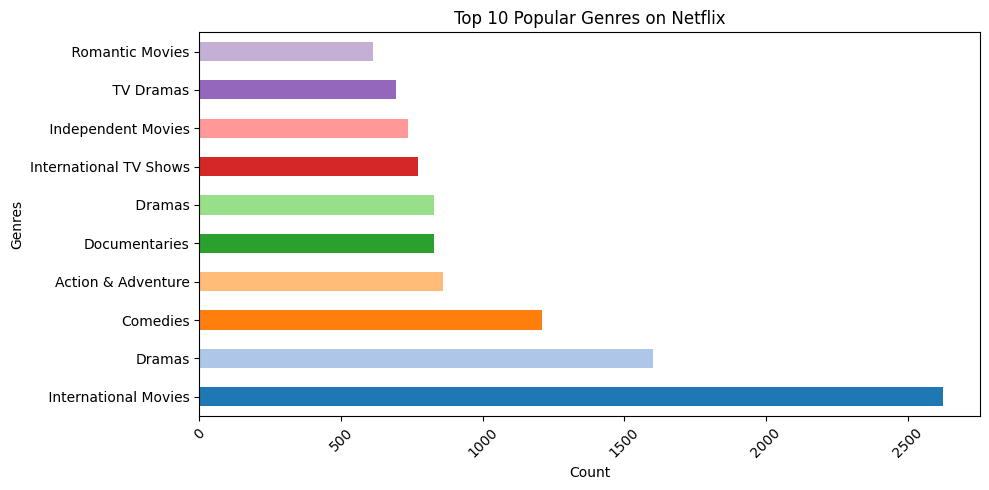

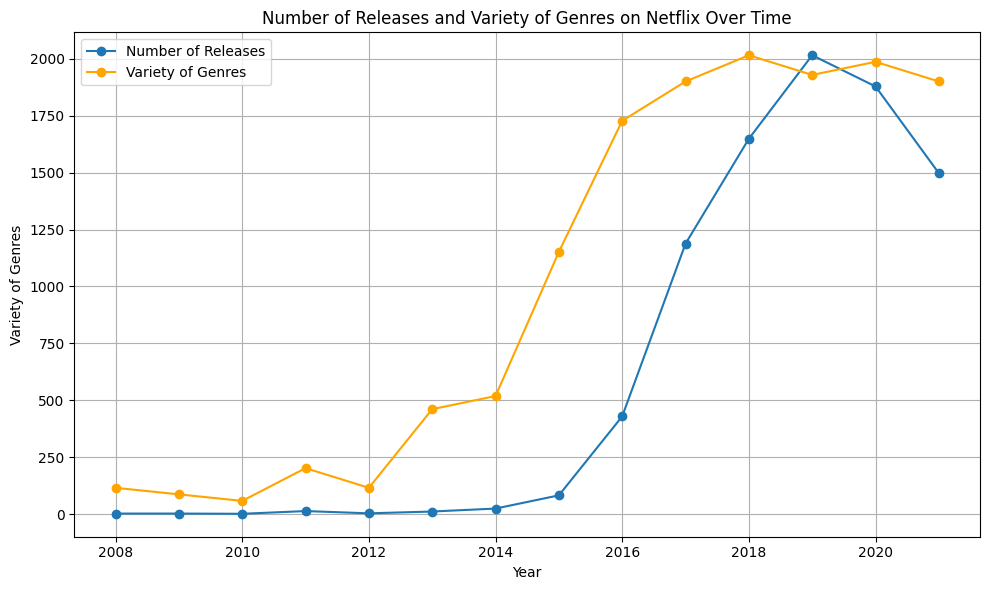

,rating_PG-13,rating_TV-MA,rating_PG,rating_TV-14,rating_TV-PG,rating_TV-Y,rating_TV-Y7,rating_R,rating_TV-G,rating_G,rating_NC-17,rating_74 min,rating_84 min,rating_66 min,rating_NR,rating_TV-Y7-FV,rating_UR,sentiment_value
rating_PG-13,1.000000,-0.184049,-0.044602,-0.138426,-0.079998,-0.046106,-0.048174,-0.076764,-0.038897,-0.016619,-0.004486,-0.002590,-0.002590,-0.002590,-0.023120,-0.006345,-0.004486,-0.029598
rating_TV-MA,-0.184049,1.000000,-0.139166,-0.431914,-0.249607,-0.143859,-0.150311,-0.239519,-0.121367,-0.051856,-0.013997,-0.008080,-0.008080,-0.008080,-0.072138,-0.019798,-0.013997,-0.078199
rating_PG,-0.044602,-0.139166,1.000000,-0.104669,-0.060489,-0.034862,-0.036426,-0.058044,-0.029412,-0.012567,-0.003392,-0.001958,-0.001958,-0.001958,-0.017482,-0.004798,-0.003392,0.005661
rating_TV-14,-0.138426,-0.431914,-0.104669,1.000000,-0.187734,-0.108199,-0.113051,-0.180146,-0.091282,-0.039001,-0.010527,-0.006077,-0.006077,-0.006077,-0.054256,-0.014890,-0.010527,0.006879
rating_TV-PG,-0.079998,-0.249607,-0.060489,-0.187734,1.000000,-0.062529,-0.065333,-0.104108,-0.052753,-0.022539,-0.006084,-0.003512,-0.003512,-0.003512,-0.031355,-0.008605,-0.006084,0.095574
rating_TV-Y,-0.046106,-0.143859,-0.034862,-0.108199,-0.062529,1.000000,-0.037654,-0.060002,-0.030404,-0.012990,-0.003506,-0.002024,-0.002024,-0.002024,-0.018071,-0.004959,-0.003506,0.164384
rating_TV-Y7,-0.048174,-0.150311,-0.036426,-0.113051,-0.065333,-0.037654,1.000000,-0.062693,-0.031767,-0.013573,-0.003664,-0.002115,-0.002115,-0.002115,-0.018882,-0.005182,-0.003664,0.023529
rating_R,-0.076764,-0.239519,-0.058044,-0.180146,-0.104108,-0.060002,-0.062693,1.000000,-0.050620,-0.021628,-0.005838,-0.003370,-0.003370,-0.003370,-0.030088,-0.008257,-0.005838,-0.129885
rating_TV-G,-0.038897,-0.121367,-0.029412,-0.091282,-0.052753,-0.030404,-0.031767,-0.050620,1.000000,-0.010959,-0.002958,-0.001708,-0.001708,-0.001708,-0.015246,-0.004184,-0.002958,0.081854
rating_G,-0.016619,-0.051856,-0.012567,-0.039001,-0.022539,-0.012990,-0.013573,-0.021628,-0.010959,1.000000,-0.001264,-0.000730,-0.000730,-0.000730,-0.006514,-0.001788,-0.001264,0.028987


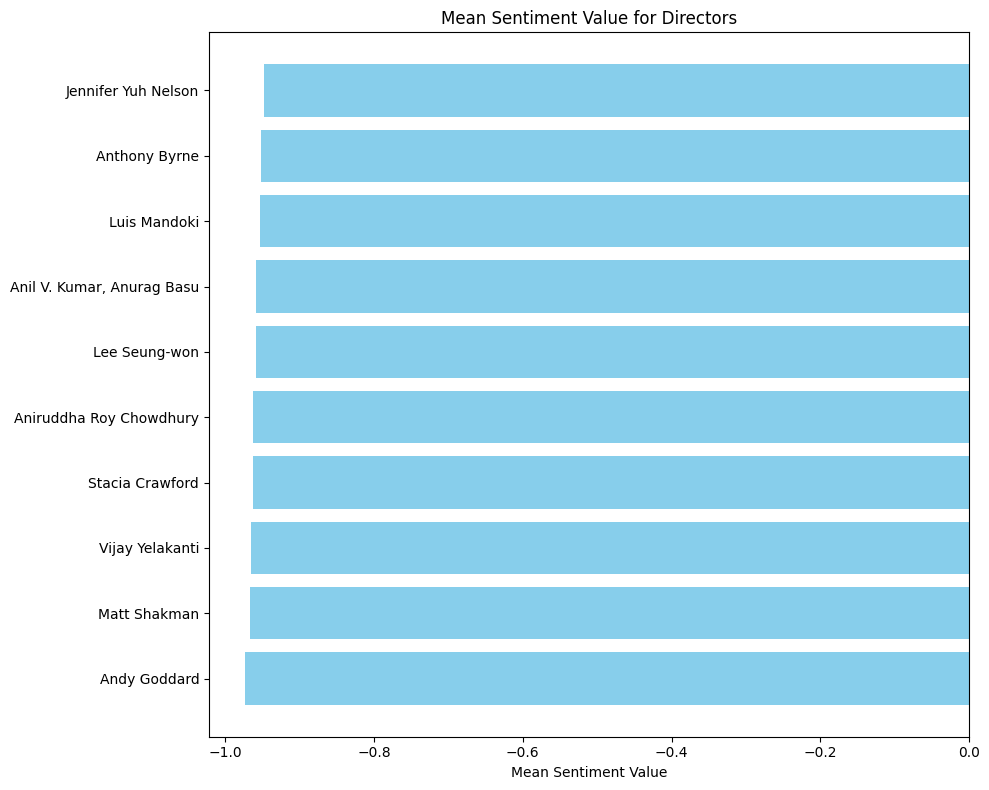

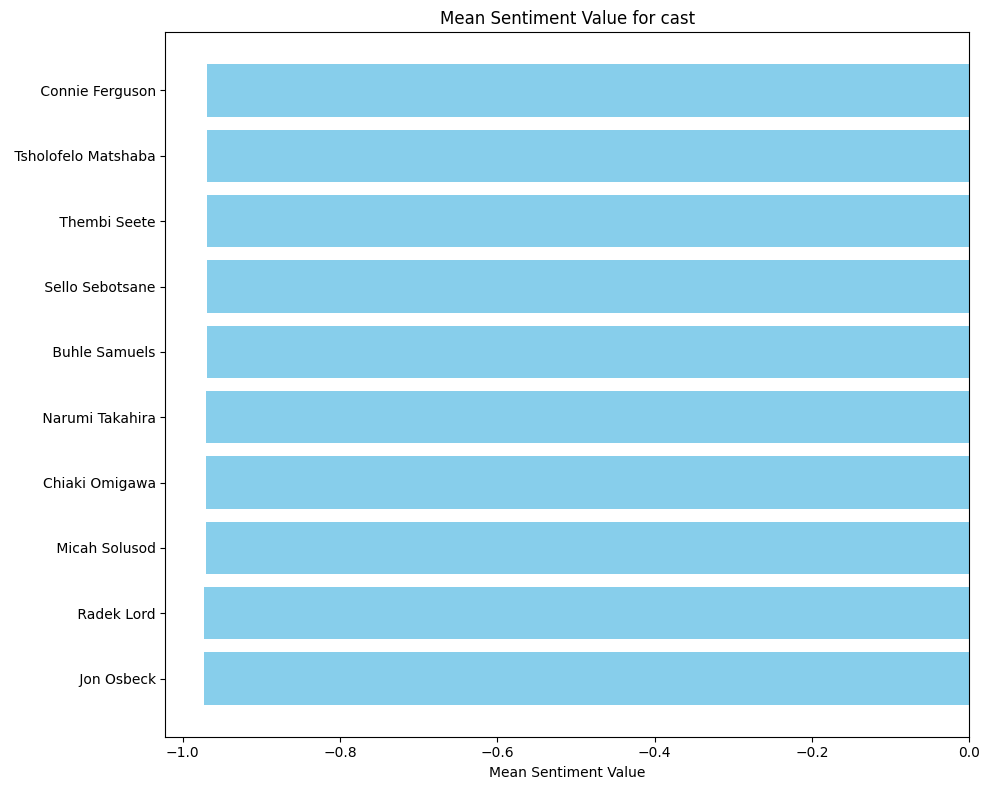

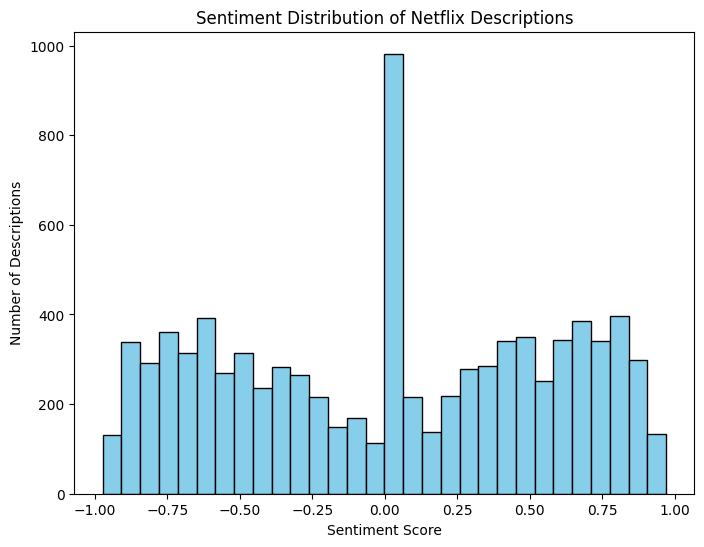

In [105]:
if __name__=="__main__":
    netflix_data = data_input('/kaggle/input/netflixshows/netflix_titles.csv')
    data_cleaning()
    q1(netflix_data)
    genre_variety_per_year,num_releases_per_year=q2(netflix_data)
    q3()
    q4()
    q5()

In [106]:
netflix_data.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'year_added', 'sentiment_value', 'rating_PG-13', 'rating_TV-MA',
       'rating_PG', 'rating_TV-14', 'rating_TV-PG', 'rating_TV-Y',
       'rating_TV-Y7', 'rating_R', 'rating_TV-G', 'rating_G', 'rating_NC-17',
       'rating_74 min', 'rating_84 min', 'rating_66 min', 'rating_NR',
       'rating_TV-Y7-FV', 'rating_UR'],
      dtype='object')

In [107]:
#extract top 10 directors based on movies count and extract sentiment analysis
director_data = netflix_data.groupby(["director","sentiment_value"]).size().reset_index(name='count')

In [108]:
director_data.sort_values(by="count",ascending=False)

,director,sentiment_value,count
5917,Unknown,0.0000,254
5967,Unknown,0.3612,36
5972,Unknown,0.4019,36
5980,Unknown,0.4767,36
5958,Unknown,0.3182,35
...,...,...,...
2177,"Jacques Perrin, Jacques Cluzaud",0.4939,1
2176,Jacob Schwab,0.0000,1
2175,Jacob LaMendola,-0.6472,1
2174,Jacob Kornbluth,0.0000,1


In [109]:
director_data.groupby("director").size().reset_index(name="count")

,director,count
0,A. L. Vijay,2
1,A. Raajdheep,1
2,A. Salaam,1
3,A.R. Murugadoss,2
4,Aadish Keluskar,1
...,...,...
4524,Çagan Irmak,1
4525,Ísold Uggadóttir,1
4526,Óskar Thór Axelsson,1
4527,Ömer Faruk Sorak,2


In [110]:
grouped_directors.head(10)

,director,Mean_Sentiment_Value
301,Andy Goddard,-0.9732
2713,Matt Shakman,-0.9668
4350,Vijay Yelakanti,-0.9648
3954,Stacia Crawford,-0.9633
319,Aniruddha Roy Chowdhury,-0.9623
2389,Lee Seung-won,-0.9590
316,"Anil V. Kumar, Anurag Basu",-0.9584
2491,Luis Mandoki,-0.9538
335,Anthony Byrne,-0.9517
1855,Jennifer Yuh Nelson,-0.9485


In [111]:
def q4():
    grouped_directors = netflix_data.groupby('director')['sentiment_value'].mean().reset_index()
    # Renaming the columns for better understanding
    grouped_directors.columns = ['director', 'Mean_Sentiment_Value']
    grouped_directors = grouped_directors.sort_values(by='Mean_Sentiment_Value', ascending=True)
    grouped_directors=grouped_directors[:10]
    # Plotting the bar graph
    plt.figure(figsize=(10, 8))
    plt.barh(grouped_directors['director'], grouped_directors['Mean_Sentiment_Value'], color='skyblue')
    plt.xlabel('Mean Sentiment Value')
    plt.title('Mean Sentiment Value for Directors')
    plt.tight_layout()

    # Displaying the plot
    plt.show()
    netflix_data['cast']=[i.split(",") for i in netflix_data['cast']]
    exploded_cast =netflix_data.explode('cast')
    grouped_cast = exploded_cast.groupby('cast')['sentiment_value'].mean().reset_index()

    # Renaming the columns for better understanding
    grouped_cast.columns = ['cast', 'Mean_Sentiment_Value']
    grouped_cast = grouped_cast.sort_values(by='Mean_Sentiment_Value', ascending=True)
    grouped_cast=grouped_cast[:10]
    # Plotting the bar graph
    plt.figure(figsize=(10, 8))
    plt.barh(grouped_cast['cast'], grouped_cast['Mean_Sentiment_Value'], color='skyblue')
    plt.xlabel('Mean Sentiment Value')
    plt.title('Mean Sentiment Value for cast')
    plt.tight_layout()

    # Displaying the plot
    plt.show()

In [112]:
grouped_directors

,director,Mean_Sentiment_Value
301,Andy Goddard,-0.9732
2713,Matt Shakman,-0.9668
4350,Vijay Yelakanti,-0.9648
3954,Stacia Crawford,-0.9633
319,Aniruddha Roy Chowdhury,-0.9623
2389,Lee Seung-won,-0.9590
316,"Anil V. Kumar, Anurag Basu",-0.9584
2491,Luis Mandoki,-0.9538
335,Anthony Byrne,-0.9517
1855,Jennifer Yuh Nelson,-0.9485


In [113]:
netflix_data['cast']

netflix_data['cast']=[i.split(",") for i in netflix_data['cast']]
exploded_cast =netflix_data.explode('cast')

AttributeError: 'list' object has no attribute 'split'

In [ ]:
display(exploded_cast)

In [ ]:
netflix_data['cast']=[i.split(",") for i in netflix_data['cast']]
exploded_cast =netflix_data.explode('cast')
grouped_cast = exploded_cast.groupby('cast')['sentiment_value'].mean().reset_index()

# Renaming the columns for better understanding
grouped_cast.columns = ['cast', 'Mean_Sentiment_Value']
grouped_cast = grouped_cast.sort_values(by='Mean_Sentiment_Value', ascending=True)
grouped_cast=grouped_cast[:10]
# Plotting the bar graph
plt.figure(figsize=(10, 8))
plt.barh(grouped_cast['cast'], grouped_cast['Mean_Sentiment_Value'], color='skyblue')
plt.xlabel('Mean Sentiment Value')
plt.title('Mean Sentiment Value for cast')
plt.tight_layout()

# Displaying the plot
plt.show()

In [ ]:
netflix_data = data_input('/kaggle/input/netflixshows/netflix_titles.csv')
data_cleaning()
